In [23]:
from os.path import abspath
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [6]:

# Create Database store raw files
spark.sql("DROP DATABASE IF EXISTS datalake CASCADE")
spark.sql("CREATE DATABASE IF NOT EXISTS datalake")

# Create Database store modified files
spark.sql("DROP DATABASE IF EXISTS gold CASCADE")
spark.sql("CREATE DATABASE IF NOT EXISTS gold")

DataFrame[]

In [7]:
# create database
# File location and type
file_location_array = [
    {"location" : "../../data/communes.csv", "name": "pop_commune", "delimiter": ";"},
    {"location" :  "../../data/Departements.csv", "name": "pop_department", "delimiter": ";"},
    {"location" :  "../../data/PC_DP_creant_logements_2013_2016.csv", "name": "construction_licence", "delimiter": ";"},
    {"location" :  "../../data/TREMI_2017_CodeBook_public8.txt", "name": "codebook", "delimiter": "\t"},
    {"location" :  "../../data/TREMI_2017_Résultats_enquête_bruts.csv", "name": "tremi", "delimiter": ";"},
    {"location" :  "../../data/anciennes_nouvelles_regions.csv", "name": "former_new_region", "delimiter": ";"},
    {"location" :  "../../data/code_commune.csv", "name": "code_commune", "delimiter": ";"},
    {"location" :  "../../data/conso_elec_gaz_annuelle_par_secteur_dactivite_agregee_commune.csv", "name": "elec", "delimiter": ";"},
    {"location" :  "../../data/donnees_synop_essentielles_omm.csv", "name": "weather", "delimiter": ";"},
    {"location" :  "../../data/dpe_france.csv", "name": "dpe_france", "delimiter": ","},
    {"location" :  "../../data/permis_amenager.csv", "name": "development_licence", "delimiter": ";"},
    {"location" :  "../../data/permis_demolir.csv", "name": "destruction_licence", "delimiter": ";"},
    {"location" :  "../../data/dep_limitrophe.csv", "name": "neighbouring_dep", "delimiter": ";"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    df = spark.read.format(file_type) \
        .option("inferSchema", infer_schema) \
        .option("header", first_row_is_header) \
        .option("sep", delimiter) \
        .load(file_location)
    if name == "weather":
        new_column_name_list= [name.replace(',','') for name in df.columns]
        df = df.toDF(*new_column_name_list)
    df.write.mode("overwrite")\
        .format("parquet") \
        .saveAsTable(f"datalake.{name}")

# GOLD

In [8]:
tremi = spark.sql("SELECT * FROM datalake.tremi")
pop_commune = spark.sql("SELECT * FROM datalake.pop_commune")
former_new_region = spark.sql("SELECT * FROM datalake.former_new_region")
dpe_france = spark.sql("SELECT * FROM datalake.dpe_france")
elec = spark.sql("SELECT * FROM datalake.elec")
construction_licence = spark.sql("SELECT * FROM datalake.construction_licence")
destruction_licence = spark.sql("SELECT * FROM datalake.destruction_licence")
development_licence = spark.sql("SELECT * FROM datalake.development_licence")
code_commune = spark.sql("SELECT * FROM datalake.code_commune")
pop_department = spark.sql("SELECT * FROM datalake.pop_department")
codebook = spark.sql("SELECT * FROM datalake.codebook")
weather_init = spark.sql("SELECT * FROM datalake.weather")

## Dictionary

In [10]:
unpivotExpr = "stack(24, '1', _1, '2', _2, '3', _3, '4', _4, '5', _5, '6', _6, '7', _7, '99', _99, '0', _0, '8', _8, '9', _9, '10', _10, '11', _11, '12', _12, '13', _13, '14', _14, '15', _15, '16', _16, '17', _17, '18', _18, '19', _19, '20', _20, '21', _21, '22', _22) AS (answer_number, answer)"
all_answer_df = codebook.select("Name","VARNUM","LABEL", F.expr(unpivotExpr)).where("answer IS NOT NULL")
count_df = all_answer_df.groupBy("VARNUM").count() # count number of possible answer to change multiplechoice question just for question with 3 answers : Yes, No ,NA
display(all_answer_df)

# get multiple questions answers and questions 
# template : question - answer 
# possible answer : Yes, No, N
df_final = (
    codebook.select(
        "VARNUM", 
        F.regexp_extract(codebook['LABEL'], ' - (.*)', 1).alias('answer_char'),
        F.regexp_extract(codebook['LABEL'], '(.*) - ', 1).alias('question_char'),
        F.reverse(F.split(F.reverse(codebook['Name']),'_').getItem(0)).alias('answer_num')
    )         
    .join(count_df, ["VARNUM"], 'inner')
    .join(all_answer_df, ["VARNUM"], 'inner')
)

# replace question with 3 answers by only one 
Dictionary = (
    df_final.select(
        F.col('Name').alias('column_name'),
        F.col('VARNUM').alias('varnum'),
        (
            F.when(
                (df_final['question_char'] != '')
                & (df_final['question_char'] != 'Variable filtre')
                & (df_final['question_char'] !='BLOCS Travaux')
                & (df_final['count']<=3), df_final['answer_char']
            )
            .otherwise(df_final['answer'])
        )
        .alias("answer_char"),
        (
            F.when(
                (df_final['question_char'] != '')
                & (df_final['question_char'] != 'Variable filtre')
                & (df_final['question_char'] !='BLOCS Travaux')
                &  (df_final['count']<=3), df_final['answer_num']
            )
            .otherwise(df_final['answer_number'])
        )
        .alias("answer_number"),
        (
            F.when(
                (df_final['question_char'] != '')
                & (df_final['question_char'] != 'Variable filtre')
                & (df_final['question_char'] !='BLOCS Travaux')
                &  (df_final['count']<=3), df_final['question_char']
            )
            .otherwise(df_final['LABEL'])
        )
        .alias("question")
    )
    .drop_duplicates()
    # Rename to fit scheme and order and add id
    .select(
        F.monotonically_increasing_id().alias('id_answer'),
        "*"
    )
)
# save as table
Dictionary.write.mode('overwrite')\
        .format("parquet") \
        .saveAsTable("Gold.Dictionary")

DataFrame[Name: string, VARNUM: int, LABEL: string, answer_number: string, answer: string]

## Answer

In [11]:
# unpivot the data to get all answers for every interestting question
unpivotExpr = "stack(62, 'main_q2_1', main_q2_1, 'main_q2_2', main_q2_2, 'main_q2_3', main_q2_3, 'main_q2_4', main_q2_4, 'main_q2_5', main_q2_5, 'main_q2_6', main_q2_6, 'main_q2_7', main_q2_7, 'main_q2_8', main_q2_8, 'main_q3_1', main_q3_1, 'main_q3_2', main_q3_2, 'main_q3_3', main_q3_3, 'main_q3_4', main_q3_4, 'main_q3_5', main_q3_5, 'main_q3_6', main_q3_6, 'main_q3_7', main_q3_7, 'main_q4_1', main_q4_1, 'main_q4_2', main_q4_2, 'main_q4_3', main_q4_3, 'main_q4_4', main_q4_4, 'main_q4_5', main_q4_5, 'main_q4_6', main_q4_6, 'main_q4_7', main_q4_7, 'main_q4_8', main_q4_8, 'main_Q70_01', main_Q70_01, 'main_Q70_02', main_Q70_02, 'main_Q70_03', main_Q70_03, 'main_Q70_04', main_Q70_04, 'main_Q70_05', main_Q70_05, 'main_Q70_06', main_Q70_06, 'main_Q70_07', main_Q70_07, 'main_Q70_08', main_Q70_08, 'main_Q70_09', main_Q70_09, 'main_Q70_10', main_Q70_10, 'main_Q70_11', main_Q70_11, 'main_Q70_12', main_Q70_12, 'main_Q70_13', main_Q70_13, 'main_Q70_14', main_Q70_14, 'main_Q71_01', main_Q71_01, 'main_Q71_03', main_Q71_03, 'main_Q71_04', main_Q71_04, 'main_Q71_05', main_Q71_05, 'main_Q71_06', main_Q71_06, 'main_Q71_07', main_Q71_07, 'main_Q71_08', main_Q71_08, 'main_Q71_09', main_Q71_09, 'main_Q71_10', main_Q71_10, 'main_Q71_11', main_Q71_11, 'main_Q71_12', main_Q71_12, 'main_Q71_13', main_Q71_13, 'main_Q71_14', main_Q71_14, 'main_Q74_1', main_Q74_1, 'main_Q74_2', main_Q74_2, 'main_Q74_3', main_Q74_3, 'main_Q74_4', main_Q74_4, 'main_Q74_5', main_Q74_5, 'main_q81_1', main_q81_1, 'main_q81_2', main_q81_2, 'main_q81_3', main_q81_3, 'main_q81_4', main_q81_4, 'main_q81_5', main_q81_5, 'main_q81_6', main_q81_6, 'main_q81_7', main_q81_7) AS (column_name, answer)"
all_answer_df = tremi.select(F.col("Respondent_Serial").alias('id_owner'), F.expr(unpivotExpr)).where("answer == 1").dropDuplicates()

# join with dictionnary to do an association table
answer = (
    all_answer_df.join(
        Dictionnary, ['column_name'], 'inner'
    )
    .select('id_owner', 'id_answer')
)

# save as table
answer.write.mode('overwrite')\
        .format("parquet") \
        .saveAsTable("Gold.Answer")

## Owner

In [12]:
owner = (
    tremi.select(
        F.col('Respondent_Serial').alias('id_owner'),
        F.col('main_rs1').alias('gender'),
        F.col('main_rs2_c').alias('age'),
        F.col('main_rs5').alias('work_state'),
        F.col('main_rs6').alias('job'),
        F.col('main_Q100').alias('home_state'),
        F.col('main_Q44').alias('arrival_date'),
        F.col('main_Q1_97').alias('has_done_renov'),
        F.col('main_rs102_c').alias('nb_persons_home'),
        F.col('main_RS182').alias('income_home'),
        F.col('main_Q73').alias('amount_help'),
        F.col('main_Q75').alias('loan_amount'),
        F.col('main_Q76').alias('loan_duration'),
        F.col('main_q77').alias('loan_rate')
    )
    .dropDuplicates()
)

# save as table
owner.write.mode('overwrite')\
        .format("parquet") \
        .saveAsTable("Gold.Owner")

## Housing

In [13]:
housing = (
    tremi.select(   
        F.col('Respondent_Serial').alias('id_owner'),
        F.when(F.col('cd_postal') < 10000, F.concat(F.lit("0"), F.col('cd_postal').cast('string')))
            .otherwise(F.col('cd_postal').cast('string'))
            .alias('postal_code'),
        F.col('main_Q101').alias('type'),
        F.col('main_Q102').alias('construction_date'),
        F.col('main_Q103').alias('heating_system'),
        F.col('main_Q104').alias('hot_water_system'),
        F.col('main_Q41q42').alias('surface'),
        F.col('main_Q1_97').alias('has_done_renov'), # inverted 1 = no renov, 2 = renov_done
        F.col('main_Q43').alias('DPE_before'),
        F.col('main_Q52').alias('thermal_comfort'),
        F.col('main_Q53').alias('energy_reduction'),
        F.col('main_Q38').alias('adjoining'),
        F.col('main_Q39').alias('n_floors'),
        F.col('main_Q40').alias('floor_nb')
    )
    .dropDuplicates()
    .select(F.monotonically_increasing_id().alias('id_housing'),"*")
)

# save as table
housing.write.mode('overwrite')\
        .format("parquet") \
        .saveAsTable("Gold.Housing")

## Municipality

In [14]:
regions = (
    development_licence.select( #table that link region and dep number
        F.col('REG').alias('former_region_number'),
        F.col('DEP').alias('department_number')
    )
    .dropDuplicates() # to reduce number of value drastically
    .join(
        pop_department.select( # to get department name
                F.col('CODDEP').alias('department_number'),
                F.col('DEP').alias('department_name')
            ),
        ['department_number'],
        'inner'
    )
    .join(
        former_new_region.select( # to get all region info
                F.col('Nouveau Code').alias('new_region_number'),
                F.col('Nouveau Nom').alias('new_region_name'),
                F.col('Anciens Code').alias('former_region_number'),
                F.col('Anciens Nom').alias('former_region_name')
            ),
        ['former_region_number'],
        'inner'
    )
    .dropDuplicates()
)

df_municipality = (
    pop_commune.select( # populations info
        F.col('DEPCOM').alias('insee_code'),
        F.col('COM').alias('municipality_name'),
        F.col('PMUN').alias('population'),
        F.col('DEPCOM').substr(0,2).alias('department_number')
    )
    .join( # dpe and ges info
        dpe_france.filter( # only take dpe between 2014 and 2016, ges and dpe that are relevant  
                (F.col('date_etablissement_dpe').between(F.lit("2014-01-01"), F.lit("2017-01-01"))) &
                (F.col('classe_consommation_energie') != 'N') &
                (F.col('classe_estimation_ges') != 'N') # N is not a valid dpe or ges
            )
            .select( # put ges and dpe as float to average them
                F.when(F.col('classe_consommation_energie') == 'A', 1.0)
                    .when(F.col('classe_consommation_energie') == 'B', 2.0)
                    .when(F.col('classe_consommation_energie') == 'C', 3.0)
                    .when(F.col('classe_consommation_energie') == 'D', 4.0)
                    .when(F.col('classe_consommation_energie') == 'E', 5.0)
                    .when(F.col('classe_consommation_energie') == 'F', 6.0)
                    .when(F.col('classe_consommation_energie') == 'G', 7.0)
                    .otherwise(0.0)
                    .alias('dpe'),
                F.when(F.col('classe_estimation_ges') == 'A', 1.0)
                    .when(F.col('classe_estimation_ges') == 'B', 2.0)
                    .when(F.col('classe_estimation_ges') == 'C', 3.0)
                    .when(F.col('classe_estimation_ges') == 'D', 4.0)
                    .when(F.col('classe_estimation_ges') == 'E', 5.0)
                    .when(F.col('classe_estimation_ges') == 'F', 6.0)
                    .when(F.col('classe_estimation_ges') == 'G', 7.0)
                    .otherwise(0.0)
                    .alias('ges'),
                F.col('code_insee_commune_actualise').alias('insee_code')
            )
            .groupBy('insee_code').agg(F.avg('dpe'), F.avg('ges'), F.count('insee_code'))
            .select(
                F.col('insee_code'),
                F.round(F.col('avg(dpe)'),2).alias('avg_dpe'),
                F.round(F.col('avg(ges)'),2).alias('avg_ges'),
                F.col('count(insee_code)').alias('n_dpe')
            ),
        ['insee_code'],
        'left_outer'
    )
    .join( # elec consumption info
        elec.filter( # only take electricity conumption between 2014 and 2016
                (F.col('Année').between(2014, 2016)) &
                (F.col('Filière') == 'Electricité')
            )
            .select(
                (F.col('Consommation Résidentiel  (MWh)') / F.col('Nombre de points Résidentiel')).alias('consumption_by_residence'),
                F.col('Code Commune').alias('insee_code')
            )
            .where('consumption_by_residence IS NOT NULL')
            .groupBy('insee_code').agg(F.round(F.avg('consumption_by_residence'),2).alias('consumption_by_residence')),
        ['insee_code'],
        'left_outer'
    )
    .join( # get postal codes
        code_commune.select(
            F.col('Code_commune_INSEE').alias('insee_code'),
            # correct postal codes interpreted as int
            F.when(F.col('Code_postal') < 10000, F.concat(F.lit("0"), F.col('Code_postal').cast('string')))
                .otherwise(F.col('Code_postal').cast('string'))
                .alias('cd_postal')
            ),
        ['insee_code'],
        'left_outer'
    )
    .join( # get construction licence
        construction_licence.filter(
                F.col('DATE_REELLE_AUTORISATION').between(F.lit("2014-01-01"), F.lit("2017-01-01"))
            )
            .select(
                F.col('NB_LGT_TOT_CREES').alias('nb_housing'),
                F.col('COMM').alias('insee_code')
            )
            .groupBy('insee_code').agg(F.sum('nb_housing').alias('n_construction_licence')),
        ['insee_code'],
        'left_outer'
    )
    .join( # get destruction licence
        destruction_licence.filter(
                F.col('DATE_REELLE_AUTORISATION').between(F.lit("2014-01-01"), F.lit("2017-01-01"))
            )
            .select(
                F.col('COMM').alias('insee_code')
            )
            .groupBy('insee_code').agg(F.count('insee_code').alias('n_destruction_licence')),
        ['insee_code'],
        'left_outer'
    )
    .join( # get development licence
        development_licence.filter(
                F.col('DATE_REELLE_AUTORISATION').between(F.lit("2014-01-01"), F.lit("2017-01-01"))
            )
            .select(
                F.col('COMM').alias('insee_code')
            )
            .groupBy('insee_code').agg(F.count('insee_code').alias('n_development_licence')),
        ['insee_code'],
        'left_outer'
    )
    .join( # get regions info and dep name
        regions,
        ['department_number'],
        'inner'
    )
    .withColumns({ # put null values to 0 to make sense
        'n_development_licence': F.when(F.col('n_development_licence').isNull(), 0).otherwise(F.col('n_development_licence')),
        'n_destruction_licence': F.when(F.col('n_destruction_licence').isNull(), 0).otherwise(F.col('n_destruction_licence')),
        'n_construction_licence': F.when(F.col('n_construction_licence').isNull(), 0).otherwise(F.col('n_construction_licence')),
        'n_dpe': F.when(F.col('n_dpe').isNull(), 0).otherwise(F.col('n_dpe')),
        # add an id for every town
        "id_municipality": F.monotonically_increasing_id()
    })
)

# reorder columns
df_municipality = df_municipality.select(
    'id_municipality',
    'cd_postal',
    'insee_code',
    'commune_name',
    'department_number',
    'department_name',
    'former_region_name',
    'former_region_number',
    'new_region_name',
    'new_region_number',
    'population',
    'n_development_licence',
    'n_construction_licence',
    'n_destruction_licence',
    'n_dpe',
    'avg_dpe',
    'avg_ges',
    'consumption_by_residence'
)

# save as table
df_municipality.write.mode('overwrite')\
        .format("parquet") \
        .saveAsTable("Gold.Municipality")

## Renovation

In [15]:
stack_expr = "stack(21, Respondent_Serial, 'roof_with_insulation', 11, main_Q5_11, main_Q6_11, main_Q18_11, main_Q20_11, Respondent_Serial, 'rooth_without_insulation', 12, main_Q5_12, main_Q6_12, main_Q18_12, main_Q20_12, Respondent_Serial, 'insulation_roof_without_renovation', 13, main_Q5_13, main_Q6_13, main_Q18_13, main_Q20_13, Respondent_Serial, 'insulation_flooring_attic', 14, main_Q5_14, main_Q6_14, main_Q18_14, main_Q20_14, Respondent_Serial, 'roof_terrace_with_insulation', 15, main_Q5_15, main_Q6_15, main_Q18_15, main_Q20_15, Respondent_Serial, 'roof_terrase_without_insulation', 16, main_Q5_16, main_Q6_16, main_Q18_16, main_Q20_16, Respondent_Serial, 'ext_wall_with_insulation', 21, main_Q5_21, main_Q6_21, main_Q18_21, main_Q20_21, Respondent_Serial, 'ext_wall_without_insulation', 22, main_Q5_22, main_Q6_22, main_Q18_22, main_Q20_22, Respondent_Serial, 'int_wall_with_insulation', 23, main_Q5_23, main_Q6_23, main_Q18_23, main_Q20_23, Respondent_Serial, 'int_wall_without_insulation', 24, main_Q5_24, main_Q6_24, main_Q18_24, main_Q20_24, Respondent_Serial, 'down_flooring_with_insulation', 31, main_Q5_31, main_Q6_31, main_Q18_31, main_Q20_31, Respondent_Serial, 'down_flooring_without_insulation', 32, main_Q5_32, main_Q6_32, main_Q18_32, main_Q20_32, Respondent_Serial, 'opening_common_areas', 41, main_Q5_41, main_Q6_41, NULL, NULL, Respondent_Serial, 'opening_accomodation', 42, main_Q5_42, main_Q6_42, main_Q18_42, main_Q20_42, Respondent_Serial, 'ext_doors', 43, main_Q5_43, main_Q6_43, main_Q18_43, main_Q20_43, Respondent_Serial, 'heating_system', 51, main_Q5_51, main_Q6_51, main_Q18_51, main_Q20_51, Respondent_Serial, 'heating_regulation', 52, main_Q5_52, main_Q6_52, main_Q18_52, main_Q20_52, Respondent_Serial, 'hot_water', 53, main_Q5_53, main_Q6_53, main_Q18_53, main_Q20_53, Respondent_Serial, 'insulation', 54, main_Q5_54, main_Q6_54, main_Q18_54, main_Q20_54, Respondent_Serial, 'ventilation_system', 55, main_Q5_55, main_Q6_55, main_Q18_55, main_Q20_55, Respondent_Serial, 'air_consitioning_system', 56, main_Q5_56, main_Q6_56, main_Q18_56, main_Q20_56) AS (id_owner, work_type, work_type_number, start_date, end_date, done_by, amount)"

renovation = (
    tremi.select(F.expr(stack_expr))
    .where("start_date IS NOT NULL") # select only renovation that have been done
    .dropDuplicates()
    .select(F.monotonically_increasing_id().alias('id_renov'), "*") # add id
)
display(renovation)

# save as table
renovation.write.mode('overwrite')\
        .format("parquet") \
        .saveAsTable("Gold.Renovation")

DataFrame[id_renov: bigint, id_owner: int, work_type: string, work_type_number: int, start_date: int, end_date: int, done_by: int, amount: int]

## Weather

In [16]:
weather = (
    weather_init.select(
        F.col("Direction du vent moyen 10 mn").alias('wind_direction'),
        F.col("Vitesse du vent moyen 10 mn").alias('wind_speed'),
        F.col("Température").alias('temp_kelvin'),
        F.col("Humidité").alias('humidity'),
        F.col("Hauteur de la base des nuages de l'étage inférieur").alias('heigh_clouds'),
        F.col("Température (°C)").alias('temp_degree'),
        F.col("Altitude").alias('altitude'),
        F.col("department (code)").alias('department_number'),
        F.col("mois_de_l_annee").alias('month'),
        F.year("Date").alias('year')
    )
    .groupBy('month', 'year', 'department_number').avg()
    .select(
        'department_number',
        'year',
        'month',
        F.round(F.col('avg(wind_direction)'),2).alias('wind_direction'),
        F.round(F.col('avg(wind_speed)'),2).alias('wind_speed'),
        F.round(F.col('avg(temp_kelvin)'),2).alias('temp_kelvin'),
        F.round(F.col('avg(humidity)'),2).alias('humidity'),
        F.round(F.col('avg(heigh_clouds)'),2).alias('heigh_clouds'),
        F.round(F.col('avg(temp_degree)'),2).alias('temp_degree'),
        F.round(F.col('avg(altitude)'),2).alias('altitude')
    )
)

# get data for departments that are not in the dataset

neigh = spark.sql("SELECT * FROM datalake.neighbouring_dep") # get neighbouring department
unpivotExpr = "stack(8, Voisin_1, Voisin_2, Voisin_3, Voisin_4, Voisin_5, Voisin_6, Voisin_7, Voisin_8) AS (neigh)"
neigh = neigh.select("Departement", F.expr(unpivotExpr)).where("neigh IS NOT NULL")

# get all departments that are not present in weather dataset
all_possible_not_dep = (
    neigh.join(
        weather.select('year', 'month').dropDuplicates()
    )
    .withColumnRenamed("Departement", "department_number")
    .join(
        weather.select('department_number', 'year', 'month').dropDuplicates(),
        ['department_number', 'month', 'year'],
        'left_anti'
    )
)

full_weather = (
    all_possible_not_dep.withColumnRenamed('department_number', 'Departement') 
    .withColumnRenamed('neigh', 'department_number') # to join on neighbors easier this way
    .join(weather, ['department_number', 'month', 'year']) # get existing values for neighbors for every date
    .groupBy('Departement', 'month', 'year').avg() # get average for every date and neighbor
    .select(
        F.col('Departement').alias('department_number'),
        'year',
        'month',
        F.round(F.col('avg(wind_direction)'),2).alias('wind_direction'),
        F.round(F.col('avg(wind_speed)'),2).alias('wind_speed'),
        F.round(F.col('avg(temp_kelvin)'),2).alias('temp_kelvin'),
        F.round(F.col('avg(humidity)'),2).alias('humidity'),
        F.round(F.col('avg(heigh_clouds)'),2).alias('heigh_clouds'),
        F.round(F.col('avg(temp_degree)'),2).alias('temp_degree'),
        F.round(F.col('avg(altitude)'),2).alias('altitude')
    ) # rename columns
    .union(weather) # get data for all departements
    .where("department_number IS NOT NULL") # remove unrelevant data
    .withColumn('department_number', F.when(F.length('department_number') == 1, F.concat(F.lit("0"), F.col('department_number'))) # uniformise department number
        .otherwise(F.col('department_number'))
    ) 
)

# save as table
full_weather.write.mode('overwrite')\
        .format("parquet") \
        .saveAsTable("Gold.Weather")

In [47]:
Dictionnary = spark.sql("SELECT * FROM Gold.Dictionnary")
Answer = spark.sql("SELECT * FROM Gold.Answer")
Owner = spark.sql("SELECT * FROM Gold.Owner")
Housing = spark.sql("SELECT * FROM Gold.Housing")
Municipality = spark.sql("SELECT * FROM Gold.Municipality")
Renovation = spark.sql("SELECT * FROM Gold.Renovation")
Weather = spark.sql("SELECT * FROM Gold.Weather")

In [192]:
def hist(dataframe, variable, condition, related_question):
    label = Dictionnary.where(f'column_name = "{related_question}"').select('answer_char','answer_number').toPandas()
    study = (
        dataframe.where(condition)
        .select(variable)
    ).toPandas()
    
    
    nb_values = study[variable].nunique()
    study[variable] = study[variable].replace(99,nb_values)
    label['answer_number'] = label['answer_number'].astype(int).replace(99,nb_values)
    label.set_index('answer_number', inplace=True)
    
    #plot
    f, ax = plt.subplots()
    ax.hist(study[variable], bins=nb_values, range=(0.5,nb_values + 0.5), rwidth=0.5)
    ax.set_title(f'{variable}')
    ax.set_xticks(range(1,nb_values + 1), label['answer_char'].sort_index(), rotation = 85)

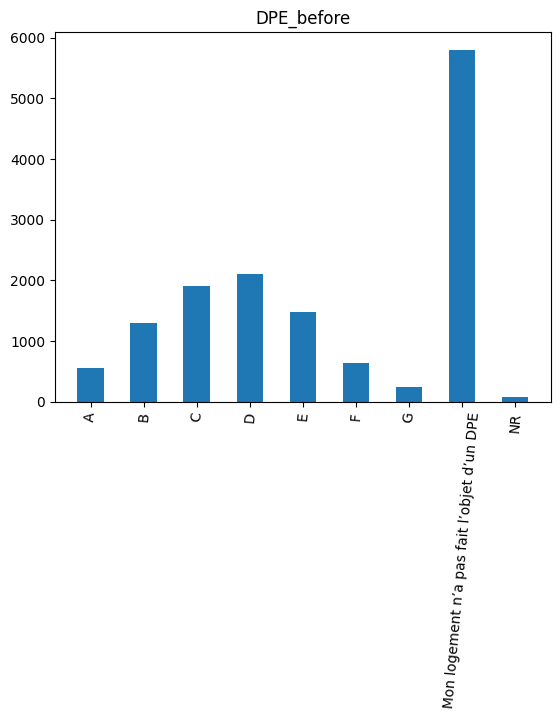

In [193]:
hist(Housing, "DPE_before", "has_done_renov = 2", 'main_Q43')